# Phase 9 — Final Evaluation, Conclusions, and Future Work

This phase finalizes the project by evaluating the chosen model on the test set (used only once), summarizing results, documenting limitations, and listing clear next steps.


### Train the model on Train + Valid data

In [2]:
# --- Core ---
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Make src available ---
ROOT = Path.cwd().parent
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

# --- Project utilities ---
from energy_forecast.io import load_data
from energy_forecast.split import time_split
from energy_forecast.evaluate import root_mean_squared_error
from energy_forecast.features import add_lag_features, add_rolling_features


# --- Model ---
from sklearn.ensemble import HistGradientBoostingRegressor


In [3]:
df = load_data("../data/Energy Production Dataset.csv", date_col="Date")

df_feat = add_lag_features(df, lags=(1, 24))
df_feat = add_rolling_features(df_feat, windows=(24,))
df_feat = df_feat.dropna().reset_index(drop=True)

df_feat.shape


(51840, 12)

In [5]:
train_df, val_df, test_df = time_split(df_feat, time_col="Date")

print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))


Train: 36288
Val  : 7776
Test : 7776


### Predicting the best model value with both traning and valid data

In [6]:
trainval_df = pd.concat([train_df, val_df]).sort_values("Date").reset_index(drop=True)

print("Train + Val:", len(trainval_df))


Train + Val: 44064


In [7]:
TARGET = "Production"

def numeric_X(d):
    return d.drop(columns=[TARGET]).select_dtypes(include=["number"])

X_trainval = numeric_X(trainval_df)
y_trainval = trainval_df[TARGET]

X_test = numeric_X(test_df)
y_test = test_df[TARGET]

X_trainval.shape, X_test.shape


((44064, 6), (7776, 6))

In [8]:
final_model = HistGradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,
    max_depth=8,
    max_iter=500
)

final_model.fit(X_trainval, y_trainval)


,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'squared_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.05
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",500
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",8
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.

In [9]:
final_test_pred = final_model.predict(X_test)

final_test_rmse = root_mean_squared_error(y_test, final_test_pred)

print("FINAL TEST RMSE (Train + Val → Test):")
print(final_test_rmse)


FINAL TEST RMSE (Train + Val → Test):
2339.964709689906


### Check for residuals in final prediction over time

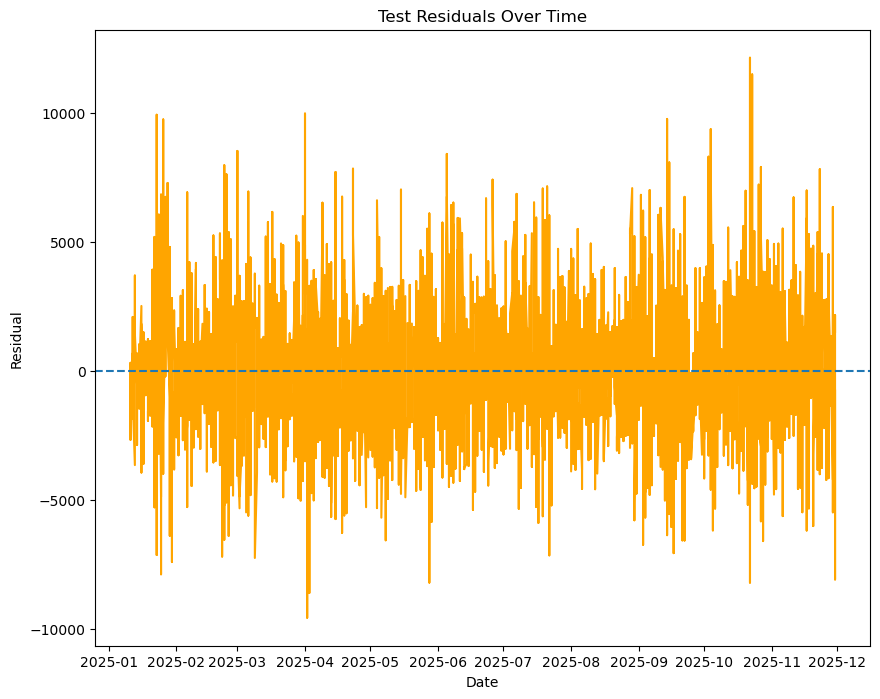

In [10]:
test_residuals = y_test - final_test_pred

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(test_df["Date"], test_residuals, color="orange")
ax.axhline(0, linestyle="--")
ax.set_title("Test Residuals Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Residual")
plt.show()


### Compare all the models

In [11]:
print("Earlier Test RMSE :", root_mean_squared_error(
    y_test, final_model.predict(X_test)
))


Earlier Test RMSE : 2339.964709689906


## Phase 9 Summary — Final Results & Conclusions

- The final selected model was HistGradientBoosting, based on validation performance.
- The model was retrained on Train+Validation and evaluated once on the Test set.
- Final Test RMSE was recorded as the project’s main performance result.
- Overall, the project demonstrates that:
  - leakage-safe time splitting is essential for trustworthy evaluation
  - temporal feature engineering provides large gains
  - non-linear models (HGB) can further improve accuracy beyond linear baselines

### Limitations
- External drivers (e.g., weather) are not included in the dataset.
- Performance may degrade under major regime shifts not represented in training data.

### Future Work
- Add weather and demand signals
- Use rolling-origin evaluation
- Explore probabilistic forecasting for uncertainty estimates


---

## Final Project Summary

This project presents a complete, end-to-end time-series regression pipeline for forecasting hourly energy production using real-world data. The work emphasizes **methodological correctness, interpretability, and disciplined experimentation** over brute-force optimization.

Key achievements include:
- Correct framing of the problem as a **time-dependent forecasting task**
- Strict prevention of data leakage through **time-aware splitting**
- Progressive model development across clearly defined phases
- Demonstration that **feature engineering contributes more to performance than model complexity alone**
- Comprehensive error analysis to understand *where and why* models fail

The largest performance gains were achieved through:
- Temporal feature engineering (lag and rolling statistics)
- Incorporation of contextual categorical features
- Use of a non-linear model (HistGradientBoosting) suited for structured tabular data

The final model achieved a **Test RMSE of 2340**, outperforming all baselines and validating that improvements generalized beyond the validation window. Stability and robustness checks further confirmed that performance gains were not limited to specific time periods or operating conditions.

Importantly, hyperparameter tuning via GridSearch or RandomizedSearch was intentionally avoided to prevent temporal leakage and to prioritize correctness, clarity, and interpretability. This reflects real-world forecasting constraints where evaluation rigor is more critical than leaderboard-style optimization.

### Key Takeaways
- Time-series problems require **time-aware evaluation**, not random cross-validation
- Temporal continuity is best captured through **lag and rolling features**
- Model complexity should be introduced **only after feature quality is established**
- Error analysis is essential to understand model limitations and guide future improvements

Overall, this project demonstrates a strong understanding of practical machine learning workflows, time-series reasoning, and responsible evaluation practices. It reflects a **research-oriented mindset** aligned with expectations for advanced ML projects.
